<a href="https://colab.research.google.com/github/elbixos/M2_Connectionnisme/blob/master/DeepMim/Cours/DeepMim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Commencons par charger nos données

In [0]:

import pandas as pd
from tensorflow import keras

dataset_path = keras.utils.get_file("evalMim.csv", "https://raw.githubusercontent.com/elbixos/M2_Connectionnisme/master/DeepMim/Sources/evalMim.csv")


column_names = ['line1','line2','line3','line4','eval']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=",", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()


,line1,line2,line3,line4,eval
138,7,5,1,1,1
139,7,5,2,0,-1
140,7,5,2,1,1
141,7,5,3,0,1
142,7,5,3,1,-1


Puis, on sépare le label (eval) des caractéristiques

In [0]:


train_labels = dataset.pop('eval')
dataset.tail()


,line1,line2,line3,line4
138,7,5,1,1
139,7,5,2,0
140,7,5,2,1
141,7,5,3,0
142,7,5,3,1


On peut aussi voir les labels

In [0]:
print(dataset.shape)

(143, 4)


In [0]:

train_labels.tail()


138    1
139   -1
140    1
141    1
142   -1
Name: eval, dtype: int64

On peut maintenant construire le modele. Pour des raisons pratiques, je l'ai placé dans un fichier spécifique que nous allons récupérer.

Je vous l'affiche mais vous ne pouvez pas le modifier aussi facilement que le reste. Pour l'editer, il faudra utiliser le **volet** de gauche qui vous donne accès aux fichiers téléhargés.


In [5]:
!wget https://raw.githubusercontent.com/elbixos/M2_Connectionnisme/master/DeepMim/Sources/mymodel.py
!cat mymodel.py

--2019-11-15 17:07:48--  https://raw.githubusercontent.com/elbixos/M2_Connectionnisme/master/DeepMim/Sources/mymodel.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 568 [text/plain]
Saving to: ‘mymodel.py’

mymodel.py          100%[===================>]     568  --.-KB/s    in 0s      

2019-11-15 17:07:48 (37.6 MB/s) - ‘mymodel.py’ saved [568/568]

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.keras import layers

class Model():
    def build_model():
        model = keras.Sequential([
          layers.Dense(32, activation='relu', input_shape=[4,]),
          layers.Dense(32, activation='relu'),
          layers.Dense(1)
        ])

        optimizer = tf.keras.optimizers.RMSprop(0.

In [6]:
import mymodel
model = mymodel.Model.build_model()


TypeError: ignored

Et regarder sa tete...

In [0]:
model.summary()


Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_144 (Dense)            (None, 32)                160       
_________________________________________________________________
dense_145 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_146 (Dense)            (None, 1)                 33        
Total params: 1,249
Trainable params: 1,249
Non-trainable params: 0
_________________________________________________________________


Essayons quelques prédictions

In [0]:
example_batch = dataset[:5]
example_batch

,line1,line2,line3,line4
0,0,0,0,0
1,1,0,0,0
2,1,1,0,0
3,2,0,0,0
4,2,1,0,0


In [0]:
example_result = model.predict(example_batch)
example_result

array([[ 0.        ],
       [ 0.00622945],
       [-0.04298818],
       [ 0.01245889],
       [-0.01324138]], dtype=float32)

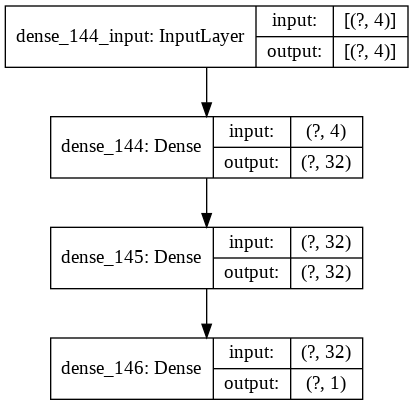

In [0]:
keras.utils.plot_model(model, 'my_first_model_with_shape_info.png', show_shapes=True)


Commencons l'entrainement

In [0]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

Voyons ce qui s'est passé

In [0]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,0.314802,0.436032,0.314802,0.891196,0.754916,0.891196,995
996,0.326533,0.436836,0.326533,0.911477,0.784147,0.911477,996
997,0.318121,0.440495,0.318121,0.835617,0.716183,0.835617,997
998,0.333132,0.446113,0.333132,0.875931,0.746999,0.875931,998
999,0.322291,0.433361,0.322291,0.816917,0.723676,0.816917,999


Avec une courbe

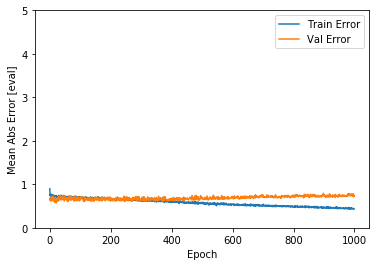

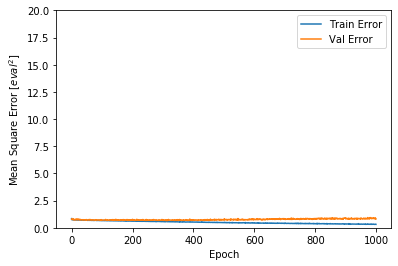

In [0]:
import matplotlib.pyplot as plt


def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [eval]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$eval^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)


Revoyons ce qui se passe maintenant en prédiction

In [0]:
example_batch = dataset[:5]
example_result = model.predict(example_batch)
example_result


array([[ 1.0138191 ],
       [-0.97938   ],
       [ 0.5574982 ],
       [ 0.36460546],
       [ 1.0174263 ]], dtype=float32)

Et on attendait

In [0]:

examples_labels = train_labels[:5]
examples_labels

0    1
1   -1
2    1
3    1
4    1
Name: eval, dtype: int64

Ca semble pas mal !

Essayons de sauver le model pendant l'apprentissage

In [0]:
import os

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)



# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 2000

history = model.fit(
  dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0, shuffle=True,
  callbacks=[PrintDot(),cp_callback])



.
Epoch 00001: saving model to training_1/cp.ckpt
.
Epoch 00002: saving model to training_1/cp.ckpt
.
Epoch 00003: saving model to training_1/cp.ckpt
.
Epoch 00004: saving model to training_1/cp.ckpt
.
Epoch 00005: saving model to training_1/cp.ckpt
.
Epoch 00006: saving model to training_1/cp.ckpt
.
Epoch 00007: saving model to training_1/cp.ckpt
.
Epoch 00008: saving model to training_1/cp.ckpt
.
Epoch 00009: saving model to training_1/cp.ckpt
.
Epoch 00010: saving model to training_1/cp.ckpt
.
Epoch 00011: saving model to training_1/cp.ckpt
.
Epoch 00012: saving model to training_1/cp.ckpt
.
Epoch 00013: saving model to training_1/cp.ckpt
.
Epoch 00014: saving model to training_1/cp.ckpt
.
Epoch 00015: saving model to training_1/cp.ckpt
.
Epoch 00016: saving model to training_1/cp.ckpt
.
Epoch 00017: saving model to training_1/cp.ckpt
.
Epoch 00018: saving model to training_1/cp.ckpt
.
Epoch 00019: saving model to training_1/cp.ckpt
.
Epoch 00020: saving model to training_1/cp.ckpt

Pour charger ce model, on ferait

In [0]:
# Create a basic model instance
model2 = build_model()

# Loads the weights
model2.load_weights(checkpoint_path)

Testons ce modele :

In [0]:
example_batch = dataset[:5]
example_result = model.predict(example_batch)
example_result


array([[ 0.97216576],
       [-1.0353711 ],
       [ 0.93465894],
       [ 0.5748678 ],
       [ 0.94473857]], dtype=float32)

pour un résultat attendu de :

In [0]:

examples_labels = train_labels[:5]
examples_labels

0    1
1   -1
2    1
3    1
4    1
Name: eval, dtype: int64

On aurait aussi pu faire...

In [0]:
# Save the weights
model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
model3 = build_model()

# Restore the weights
model3.load_weights('./checkpoints/my_checkpoint')

# Evaluate the model
loss,mae,mse= model3.evaluate(dataset,  train_labels, verbose=2)
print(loss)


143/143 - 0s - loss: 0.2982 - mean_absolute_error: 0.3542 - mean_squared_error: 0.2982
0.2982306855541843


Voyons une utilisation en prédiction telle qu'elle serait faite dans le jeu...


In [0]:
import numpy as np

board=[7,5,3,1]
npboard = np.asarray([board])
print(npboard.shape)
model2.predict(npboard)

(1, 4)


array([[-0.933745]], dtype=float32)

Evaluons la qualité de notre apprentissage

In [0]:
!wget https://raw.githubusercontent.com/elbixos/M2_Connectionnisme/master/DeepMim/Sources/testLearningEvaluation.py
!python testLearningEvaluation.py

--2019-11-14 18:12:10--  https://raw.githubusercontent.com/elbixos/M2_Connectionnisme/master/DeepMim/Sources/testLearningEvaluation.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1467 (1.4K) [text/plain]
Saving to: ‘testLearningEvaluation.py’

testLearningEvaluat 100%[===================>]   1.43K  --.-KB/s    in 0s      

2019-11-14 18:12:10 (131 MB/s) - ‘testLearningEvaluation.py’ saved [1467/1467]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
2019-11-14 18:12:15.892619: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-11-14 18:12:15.892873: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x17b7800 initialized for platform Host (this does not guarantee that XLA will

In [0]:
checkpoint_path = "training_1/cp.ckpt"

model2 = build_model()

# Loads the weights
model2.load_weights(checkpoint_path)


example_batch = dataset[:5]
example_result = model2.predict(example_batch)
print(example_result)

examples_labels = train_labels[:5]
print(examples_labels)

[[ 0.9687465 ]
 [-1.0529017 ]
 [ 0.973741  ]
 [ 0.91817516]
 [ 0.92752796]]
0    1
1   -1
2    1
3    1
4    1
Name: eval, dtype: int64


Incrustons tout ceci dans un jeu d'allumettes

In [0]:
def computeErrors(x,labels, predictions):
  truths = labels.values
  nbErrors=0
  for i in range(len(truths)) :
    if truths[i]*predictions[i][0] <=0 :
      nbErrors += 1
      print(i,x.iloc[i,0],x.iloc[i,1],x.iloc[i,2],x.iloc[i,3],truths[i],predictions[i][0])
  return nbErrors

pred = model2.predict(dataset)

computeErrors(dataset,train_labels,pred)

116 7 2 0 0 1 -0.70628583
117 7 2 1 0 -1 1.4369951
118 7 3 0 0 -1 0.258227
122 7 3 1 1 -1 1.2546033
130 7 4 1 0 1 -0.39680767
133 7 4 2 1 -1 1.611327
134 7 4 3 0 -1 1.1916267
136 7 5 0 0 1 -0.036058307
138 7 5 1 1 1 -0.4884063
141 7 5 3 0 1 -0.6992934


10

In [0]:
!wget https://raw.githubusercontent.com/elbixos/M2_Connectionnisme/master/DeepMim/Sources/player.py

--2019-11-14 19:41:31--  https://raw.githubusercontent.com/elbixos/M2_Connectionnisme/master/DeepMim/Sources/player.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6289 (6.1K) [text/plain]
Saving to: ‘player.py’

player.py           100%[===================>]   6.14K  --.-KB/s    in 0s      

2019-11-14 19:41:31 (102 MB/s) - ‘player.py’ saved [6289/6289]



Et on va pouvoir tester

In [0]:
import player
import random

def displayBoard(board) :
        """
        display the board
        """
        for i in range(len(board)) :
            print(i ,":  ", end="")
            for j in range(board[i]) :
                print("I", end = "")
            print("")


def drawMatches (line, nbMatches,board):
    """
    Draw some matches on the current board.

    It check if the proposal is valid.
    """
    if (isValidStrategy(line, nbMatches,board)) :
        board[line]-=nbMatches
    else :
        print ("You tried something bad")

def isFinished (board):
    """
    Tell if the game is finished or not
    (finished if no matches remains)
    """
    if countMatches(board) == 0:
        return True
    return False


def countMatches (board):
    """
    Count matches on the board
    """

    nbAll =0
    for ligne in board:
        if ligne >= 0:
            nbAll+=ligne
    return nbAll

def isValidStrategy (line, nbMatches, board):
    """
    test if a strategy is valid for the current state of the Board

    One could ask if a strategy is valid for a different board. If so,
    pass the board as a parameter
    """
    if (line < 0 or line >=4):
        return False

    if nbMatches < 1 or nbMatches >3 :
        return False

    if board[line]-nbMatches < 0:
        return False

    return True

def changePlayer(numJoueur):
    numJoueur = (numJoueur+1)%2
    return numJoueur


victories=0
nbGames = 1

p1=player.IADeepPlayer()
p2=player.IARandomPlayer()


for i in range(nbGames):

    board = [7 , 5, 3, 1]
    numJoueur = 0

    #print ("avec ",board ,"j'aurais ce resultat", evaluate(board,False,0))
    #print ("avec ",board ,"je joue ", IAMakeChoice(board))



    draw = random.random()
    if draw <0.5:
        players=[p1,p2]
        IA=0
    else :
        players=[p2,p1]
        IA=1


    while(not isFinished(board)):
            line, nbMatches = players[numJoueur].makeChoice(board)
            drawMatches(line, nbMatches,board)
            numJoueur = changePlayer(numJoueur)

    if numJoueur == IA:
        victories+=1

print ("IA wins in ",victories, "over ",nbGames)


IA wins in  0 over  1
